# INFO8010: Homework 2

In the previous homework, you learned how to program your first neural network starting from the very first principles of deep learning. If you managed to solve last assignment without any problems **congratulations!** If that was not the case **don't worry**, here's a second assignment for you which you can use to get better at deep learning.

In this homework we will see some slighly more complicated deep learning concepts: we will start by taking a look at some of PyTorch's functionalities that are necessary for training deep networks efficiently. We will then train our first neural networks for tackling different image classification tasks, learn to build custom datasets and explore how to train a CNN.  

The strucutre of the notebook is identical to the one of the previous homework. Similarly to last time, you have to submit the notebook **with your solutions** to the exercises. When you encounter a `# your code` comment, you have to write some code yourself and you have to discuss the code/results when you see the instruction

> your discussion

Without further ado let's start by importing the libraries we will need throughout this assignment!

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from PIL import Image
from torchvision import datasets, transforms, utils

In [2]:
# As of 2022/02/23, the CIFAR10 dataset SSL certificate is outdated which prevents its download.
# The following deactivates the verification of the SSL certificates, but
# never reproduce this unless you absolutely trust the source.
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## 1. Dataloaders

Today's first concept are PyTorch's dataloaders. As you have seen during the theoretical lectures, one of the main ingredients for successfully training deep learning models is data, **lots of data**. 

As you can easily imagine, it is not possible to load datasets of millions of images into the memory of your machine. Furthermore, these images come in a form that does not make it possible to exploit the tensor operations we have seen in the previous assignment. 

To deal with these issues (and many more of them) we can use [dataloaders](https://pytorch.org/docs/stable/data.html), a data loading utility that allows us to deal with large datasets efficiently. In what follows, you are given your first example of dataloader which will use the popular [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. 

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, transform=transform)

Files already downloaded and verified


Let's explain what we just did. Thanks to PyTorch's [torchvision](https://pytorch.org/vision/stable/index.html) sub-library, we just downloaded the CIFAR10 dataset on our machine. The dataset was stored in the `./data` folder and comes in two different forms thanks to the use of the `train` flag: a version that can be used as training set, and a version that can be used as testing set. These two datasets are subclasses of `torch`'s `data.Dataset` class. We will see later what this `data.Dataset` class consists in exactly. Torchvision also allows us to define a set of image transformations which we have defined at the beginning of this cell: in this case we would like to convert our images to tensors, see the [documentation](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.ToTensor) for an exact description of this transformation.

Now that we have defined which dataset we would like to use, and the form in which we would like to have our images, we can create our first data loader. Data loaders are objects over which you can iterate and that load, transform and return mini-batches of inputs/targets at each iteration. The advantage of data loaders is that they (can) perform pre-processing of the data in parallel, i.e. in several concurrent worker pools.

Here, we create two data loaders that return mini-batches of 4 elements at each iteration. When using stochastic gradient descent (SGD), the training data loader should shuffle the training dataset. 

In [4]:
trainloader = data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

Before training anything, let's take a look at the images we just downloaded.

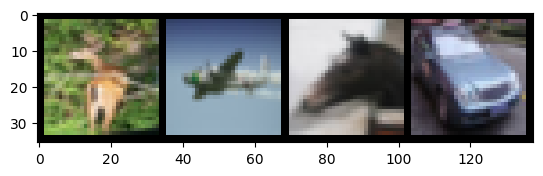

deer plane horse car


In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def show_images(img):
    plt.imshow(transforms.functional.to_pil_image(img))
    plt.show()

images, labels = next(iter(trainloader))
show_images(utils.make_grid(images))
print(*[classes[l] for l in labels])

The `transforms` module comes also in as very handy for performing other type of data transformations: here's an example which transforms the CIFAR10 images into gray scaled images.

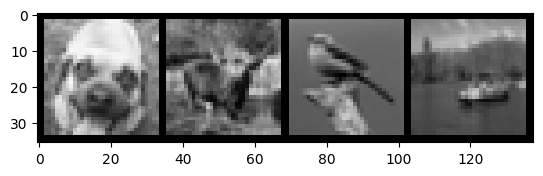

dog deer bird ship


In [6]:
transform = transforms.Compose([transforms.Grayscale(), transforms.ToTensor()])
gray_scaled_trainset = datasets.CIFAR10(root='./data', train=True, transform=transform)
gray_scaled_trainloader = data.DataLoader(gray_scaled_trainset, batch_size=4, shuffle=True, num_workers=2)

images, labels = next(iter(gray_scaled_trainloader))
show_images(utils.make_grid(images))
print(*[classes[l] for l in labels])

### 1.1 Transforms

Al remembered from the theoretical lectures that one way to make neural networks converge faster is to **normalize** the pixel values. He wrote the following code snippet to normalize his training set, but he encountered an error.

In [7]:
transform = transforms.Compose([
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.ToTensor(),
])
bugged_trainset = datasets.CIFAR10(root='./data', train=True, transform=transform)
bugged_trainloader = data.DataLoader(bugged_trainset, batch_size=4, shuffle=True, num_workers=2)

images, labels = next(iter(bugged_trainloader))
show_images(utils.make_grid(images))  # should look weird due to normalization
print(*[classes[l] for l in labels])

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/duvu/.local/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 309, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/home/duvu/.local/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/duvu/.local/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/duvu/.local/lib/python3.10/site-packages/torchvision/datasets/cifar.py", line 119, in __getitem__
    img = self.transform(img)
  File "/home/duvu/.local/lib/python3.10/site-packages/torchvision/transforms/transforms.py", line 95, in __call__
    img = t(img)
  File "/home/duvu/.local/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/duvu/.local/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/duvu/.local/lib/python3.10/site-packages/torchvision/transforms/transforms.py", line 277, in forward
    return F.normalize(tensor, self.mean, self.std, self.inplace)
  File "/home/duvu/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py", line 348, in normalize
    raise TypeError(f"img should be Tensor Image. Got {type(tensor)}")
TypeError: img should be Tensor Image. Got <class 'PIL.Image.Image'>


Fix his mistake.

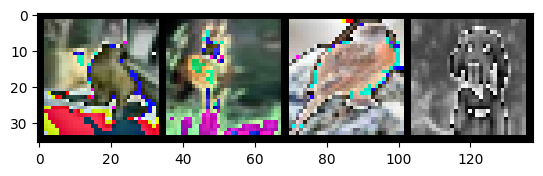

cat deer bird dog


In [8]:
# your code
transform = transforms.Compose([
    transforms.ToTensor(), # convert image to tensor first
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # normalize after tensor conversion
])

fixed_trainset = datasets.CIFAR10(root='./data', train=True, transform=transform)
fixed_trainloader = data.DataLoader(fixed_trainset, batch_size=4, shuffle=True, num_workers=2)

images, labels = next(iter(fixed_trainloader))
show_images(utils.make_grid(images))  # should look weird due to normalization
print(*[classes[l] for l in labels])

Al also remembers that, with image datasets, a common practice to increase the robustness of neural networks is **data augmentation**. He wants to apply random flips (vertical and horizontal) and random color changes to his training set, but he does not know how to. Could you help him?

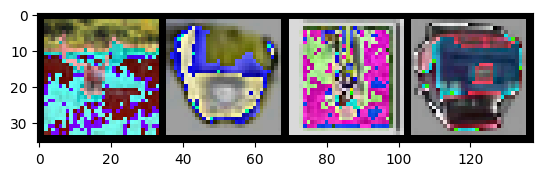

deer dog dog car


In [9]:
# your code
augmented_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance of flipping horizontally
    transforms.RandomVerticalFlip(p=0.5),    # 50% chance of flipping vertically
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize
])

augmented_trainset = datasets.CIFAR10(root='./data', train=True, transform=augmented_transform)
augmented_trainloader = data.DataLoader(augmented_trainset, batch_size=4, shuffle=True, num_workers=2)

images, labels = next(iter(augmented_trainloader))
show_images(utils.make_grid(images))  # Display augmented images
print(*[classes[l] for l in labels])

### 1.2 Running operations on a GPU

As you may know, one important aspect of deep learning is that large models can be trained efficiently on specialized hardwares such as Graphical Processing Units (GPUs) or Tensorial Processing Units (TPUs). PyTorch allows you to perform operations on GPUs very easily by transferring the concerned models and/or tensors to GPUs.

However, to do so, you need a CUDA compatible GPU.

In [10]:
torch.cuda.is_available()

True

If the result of the previous cell is `True`, everything is ready to run on the GPU and you can continue. Otherwise it means you do not have any GPU that is compatible with the `torch` version installed on your machine. In this case, we invite you to use [Google Colab](https://colab.research.google.com/) to do the rest of this homework. Do not forget to ask Colab for a GPU (in Runtime > Change runtime type > Hardware accelerator).

In [11]:
device = 'cuda'

Let's compare the speed of tensor operations on GPU and CPU. 

In [12]:
A = torch.randn(1000, 100000)
B = torch.randn(100000, 1)

# on CPU
%timeit A @ B

6.85 ms ± 48.5 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
A = torch.randn((1000, 100000), device=device)
B = torch.randn((100000, 1), device=device)

# on GPU
%timeit A @ B

1.61 ms ± 93 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Instead of directly creating a tensor on the GPU you may also transfer a model or a tensor on the GPU, for example we can transfer a simple MLP on the GPU and then back to the CPU as follows.

In [14]:
# create MLP on CPU
mlp = nn.Sequential(
    nn.Linear(3, 512),
    nn.ReLU(), 
    nn.Linear(512, 512),
    nn.ReLU(), 
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 1),
    nn.Sigmoid(),
)

# forward pass on CPU
x = torch.randn(256, 3)
%timeit mlp(x)

# transfer MLP to GPU (in-place)
mlp.to(device)

# forward pass on GPU
x = x.to(device)
%timeit mlp(x)

# release the GPU memory
mlp.to('cpu')
x = x.to('cpu')

542 μs ± 3.35 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
90 μs ± 245 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


As you may notice, computations are much faster on the GPU. However, data transfer between GPU and CPU (and vice-versa) is usually very slow. We recommend to reduce the transfers of data between GPU and CPU as much as possible. For example when you want to save your loss after each iteration, in order to avoid a memory leak, you should prefer doing `.detach()` rather than `.cpu()` or `.item()`.

## 2.  Classifying the CIFAR10 dataset with an MLP

Now that you know how to handle datasets, we are ready to properly train today's first deep learning model on the CIFAR10 dataset. Before we dive into it, **do not underestimate** the importance of properly pre-processing the data before training neural networks. This step is as important as defining the neural architectures themselves, but is very often overlooked.

In this exercise you are provided with an already defined multi-layer perceptron that you can train to classify CIFAR10 images. The structure of the network is already defined, yet some crucial hyperparameters are missing. It is your job to fill them in and successfully train the network. As part of the exercise, you are also required to monitor the evolution of training: this usually consists in checking how the training and testing losses evolve during training and keeping track of the model's accuracy on the testing set. Report these statistics with some plots. In addition, transfer the network and the mini-batches on GPU to speed up training.

Fill in the code below, discuss your choices and your results. Are you satisfied with the final accuracy?

In [15]:
input_features = 32 * 32 * 3 # 32x32 pixels with 3 color channels
output_features = 10 # 10 classes
hidden_features = 200 # your code
learning_rate = 0.0001 
num_epochs = 20

class MLP(nn.Sequential):
    def __init__(self, input_features, output_features, hidden_features):
        super().__init__(
            nn.Flatten(),
            nn.Linear(input_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, output_features),
        )
    
network = MLP(input_features, output_features, hidden_features)

# your code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
network.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = datasets.CIFAR10(root='./data', train=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

def train(num_epochs):
    train_avg_loss = []
    test_avg_loss = []
    test_accuracy = []

    for i in range(num_epochs):
        train_losses = []
        test_losses = []
        
        # Training phase
        network.train() # Set to training mode
        for x, y in trainloader:
            # your code
            x, y = x.to(device), y.to(device) # Move data to GPU
            
            pred = network(x)
            loss = criterion(pred, y)
            train_losses.append(loss.detach()) # Store loss
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Testing phase
        network.eval() # Set to evaluation mode
        with torch.no_grad():   
            correct = 0
            
            for x, y in testloader:
                # your code
                x, y = x.to(device), y.to(device)
                
                pred = network(x)
                loss = criterion(pred, y)
                test_losses.append(loss)
                
                y_pred = pred.argmax(dim=-1)
                correct = correct + (y_pred == y).sum()

        accuracy = correct / len(testset)
            
        # your code
        train_avg_loss.append(sum(train_losses) / len(train_losses))
        test_avg_loss.append(sum(test_losses) / len(test_losses))
        test_accuracy.append(accuracy)
        print(f"Epoch {i+1}/{num_epochs}: Train Loss: {train_avg_loss[-1]:.4f}, Test Loss: {test_avg_loss[-1]:.4f}, Accuracy: {accuracy:.4f}")

    # your code
    return train_avg_loss, test_avg_loss, test_accuracy

In [16]:
train_avg_loss, test_avg_loss, test_accuracy = train(num_epochs)

Epoch 1/20: Train Loss: 1.8067, Test Loss: 1.6195, Accuracy: 0.4285
Epoch 2/20: Train Loss: 1.5632, Test Loss: 1.5229, Accuracy: 0.4612
Epoch 3/20: Train Loss: 1.4715, Test Loss: 1.4732, Accuracy: 0.4788
Epoch 4/20: Train Loss: 1.4046, Test Loss: 1.4270, Accuracy: 0.4980
Epoch 5/20: Train Loss: 1.3490, Test Loss: 1.3877, Accuracy: 0.5158
Epoch 6/20: Train Loss: 1.2966, Test Loss: 1.3767, Accuracy: 0.5188
Epoch 7/20: Train Loss: 1.2514, Test Loss: 1.3499, Accuracy: 0.5234
Epoch 8/20: Train Loss: 1.2100, Test Loss: 1.3414, Accuracy: 0.5293
Epoch 9/20: Train Loss: 1.1727, Test Loss: 1.3357, Accuracy: 0.5303
Epoch 10/20: Train Loss: 1.1389, Test Loss: 1.3394, Accuracy: 0.5287
Epoch 11/20: Train Loss: 1.1041, Test Loss: 1.3247, Accuracy: 0.5333
Epoch 12/20: Train Loss: 1.0730, Test Loss: 1.3265, Accuracy: 0.5377
Epoch 13/20: Train Loss: 1.0428, Test Loss: 1.3293, Accuracy: 0.5404
Epoch 14/20: Train Loss: 1.0146, Test Loss: 1.3217, Accuracy: 0.5454
Epoch 15/20: Train Loss: 0.9884, Test Loss:

Plot the statistics below and discuss your hyperparameter choices.

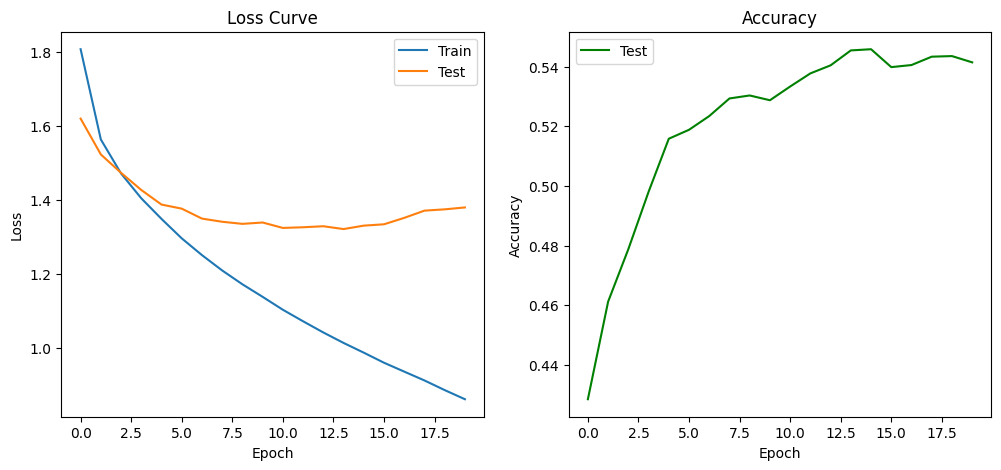

In [17]:
# your code
train_avg_loss = [loss.item() if torch.is_tensor(loss) else loss for loss in train_avg_loss]
test_avg_loss = [loss.item() if torch.is_tensor(loss) else loss for loss in test_avg_loss]
test_accuracy = [acc.item() if torch.is_tensor(acc) else acc for acc in test_accuracy]

# Plot Loss Curves
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(train_avg_loss, label="Train")
plt.plot(test_avg_loss, label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

# Plot Accuracy Curve
plt.subplot(1,2,2)
plt.plot(test_accuracy, label="Test", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")

plt.show()

**Discussion**:
- The model converges properly on the training data, but the test accuracy only hits around 54%.
- Overfitting is happening after around epoque 11. While train loss keeps dropping, test loss increases. Besides, test accuracy plateaus or declines.
- Alternatively, CNNs could improve the accuracy as well as decrease the loss because it could extract the features.

## 3.  Create a custom dataset

Sometimes you would like to train a model on your own dataset, which will very likely not be part of `torchvision`. To overcome this you can create a custom dataset class which will handle the data for you. This can be done by inheriting from `torch`'s `data.Dataset` class and defining the methods `__len__` and `__getitem__` (see the [documentation](https://pytorch.org/docs/stable/data.htm)).

In this exercise your goal is to program a custom dataset class which you will later use for training a CNN. We will use the Kaggle Cats and Dogs dataset which you can download from [here](https://www.microsoft.com/en-us/download/details.aspx?id=54765). Note that some images may have different shapes. It is up to you to deal with this elegantly. In addition, some images may be corrupted. You can simply remove those. 

When programming a custom dataset class, you have to start by defining the constructor, which will get as input the location of your dataset, whether the images that will be returned will serve for training or testing, and some other potential attributes. For this exercise we will be using 20000 images for training and 5000 images for testing. For the `__getitem__` function you may find the `PIL.Image.open` useful. Do not forget to transform the images into tensors and return the image labels as well ($0$ or $1$).

In [19]:
# your code
import os
import matplotlib.pyplot as plt 
from PIL import Image
import torch.utils.data as data
from torchvision import transforms, utils

class CatAndDogsDataset(data.Dataset):
    def __init__(self, root_dir, train=True):
        """Initializes a dataset containing images and labels."""
        super().__init__()
        # your code
        self.transform = transforms.Compose([
            transforms.Resize((32, 32)), 
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
        cat_dir = os.path.join(root_dir, 'Cat')
        dog_dir = os.path.join(root_dir, 'Dog')
        cat_images = [os.path.join(cat_dir, f) for f in os.listdir(cat_dir) if f.endswith('.jpg')]
        dog_images = [os.path.join(dog_dir, f) for f in os.listdir(dog_dir) if f.endswith('.jpg')]

        if train:
            self.image_paths = cat_images[:10000] + dog_images[:10000]
        else:
            self.image_paths = cat_images[10000:12500] + dog_images[10000:12500]

        self.labels = [0]*10000 + [1]*10000 if train else [0]*2500 + [1]*2500

        valid_paths, valid_labels = [], []
        for path, label in zip(self.image_paths, self.labels):
            try:
                with Image.open(path) as img:
                    img.verify()
                valid_paths.append(path)
                valid_labels.append(label)
            except:
                continue

        self.image_paths = valid_paths
        self.labels = valid_labels

    def __len__(self):
        """Returns the size of the dataset."""
        # your code
        return len(self.image_paths)

    def __getitem__(self, index):
        """Returns the index-th data item of the dataset."""
        # your code
        img_path = self.image_paths[index]
        label = self.labels[index]

        with Image.open(img_path) as img:
            img = img.convert("RGB")  # Ensure 3 channels
            img = self.transform(img)

        return img, label

Let us have a quick look at these samples.

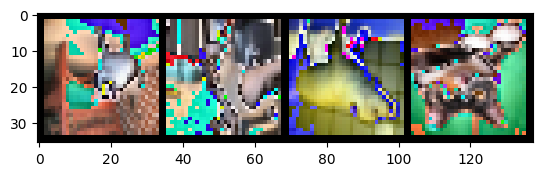

Cat Dog Dog Cat


In [ ]:
my_dataset = CatAndDogsDataset('data/kagglecatsanddogs_5340/PetImages/', train=True)
my_loader = data.DataLoader(my_dataset, batch_size=4, shuffle=True, num_workers=2)

# your code
def show_images(img):
    plt.imshow(transforms.functional.to_pil_image(img)) # convert tensor back to PIL image
    plt.show()

classes = ('Cat', 'Dog')
images, labels = next(iter(my_loader))
show_images(utils.make_grid(images))
print(*[classes[l] for l in labels])

## 4. Classifying the Cats and Dogs dataset with a CNN

As we have seen in class, classifying images with a multi-layer perceptron isn't really a good idea. Convolutional Neural Networks (CNN) are in fact a much better option for this task. It is now your job to create your custom CNN and train it on the Cats and Dogs Dataset.

Similarly to what you have done when classifying the CIFAR10 dataset you are again required to report and discuss the performance of your model.

In [32]:
# your code
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Model
class ConvNet(nn.Sequential):
    def __init__(self):
        super().__init__(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Linear(512, 2)  # output: 2 classes because we using CrossEntropyLoss
        )

device = 'cuda' if torch.cuda.is_available() else 'cpu'
network = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)

# Load data
trainset = CatAndDogsDataset('kagglecatsanddogs_5340/PetImages/', train=True)
testset = CatAndDogsDataset('kagglecatsanddogs_5340/PetImages/', train=False)
trainloader = data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

def train(num_epochs):
    train_avg_loss, test_avg_loss, test_accuracy = [], [], []
    for i in range(num_epochs):
        train_losses, test_losses = [], []
        network.train()
        for x, y in trainloader:
            x, y = x.to(device), y.to(device)
            pred = network(x)
            loss = criterion(pred, y)
            train_losses.append(loss.detach().cpu())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        network.eval()
        correct = 0
        with torch.no_grad():
            for x, y in testloader:
                x, y = x.to(device), y.to(device)
                pred = network(x)
                loss = criterion(pred, y)
                test_losses.append(loss.detach().cpu())
                y_pred = pred.argmax(dim=1)
                correct += (y_pred == y).sum().item()

        accuracy = correct / len(testset)
        train_avg_loss.append(sum(train_losses) / len(train_losses))
        test_avg_loss.append(sum(test_losses) / len(test_losses))
        test_accuracy.append(accuracy)
        print(f"Epoch {i+1}/{num_epochs}: Train Loss: {train_avg_loss[-1]:.4f}, Test Loss: {test_avg_loss[-1]:.4f}, Accuracy: {accuracy:.4f}")

    return train_avg_loss, test_avg_loss, test_accuracy


In [33]:
train_avg_loss, test_avg_loss, test_accuracy = train(num_epochs=100)

Epoch 1/100: Train Loss: 0.6275, Test Loss: 0.6017, Accuracy: 0.6756
Epoch 2/100: Train Loss: 0.5641, Test Loss: 0.5459, Accuracy: 0.7172
Epoch 3/100: Train Loss: 0.5305, Test Loss: 0.5188, Accuracy: 0.7414
Epoch 4/100: Train Loss: 0.5140, Test Loss: 0.5222, Accuracy: 0.7444
Epoch 5/100: Train Loss: 0.4870, Test Loss: 0.4727, Accuracy: 0.7694
Epoch 6/100: Train Loss: 0.4692, Test Loss: 0.4704, Accuracy: 0.7734
Epoch 7/100: Train Loss: 0.4573, Test Loss: 0.5194, Accuracy: 0.7348
Epoch 8/100: Train Loss: 0.4288, Test Loss: 0.4537, Accuracy: 0.7846
Epoch 9/100: Train Loss: 0.4200, Test Loss: 0.4412, Accuracy: 0.7876
Epoch 10/100: Train Loss: 0.3995, Test Loss: 0.4833, Accuracy: 0.7780
Epoch 11/100: Train Loss: 0.3887, Test Loss: 0.4529, Accuracy: 0.7902
Epoch 12/100: Train Loss: 0.3725, Test Loss: 0.4381, Accuracy: 0.8026
Epoch 13/100: Train Loss: 0.3584, Test Loss: 0.4256, Accuracy: 0.8058
Epoch 14/100: Train Loss: 0.3409, Test Loss: 0.4758, Accuracy: 0.7924
Epoch 15/100: Train Loss: 0.3

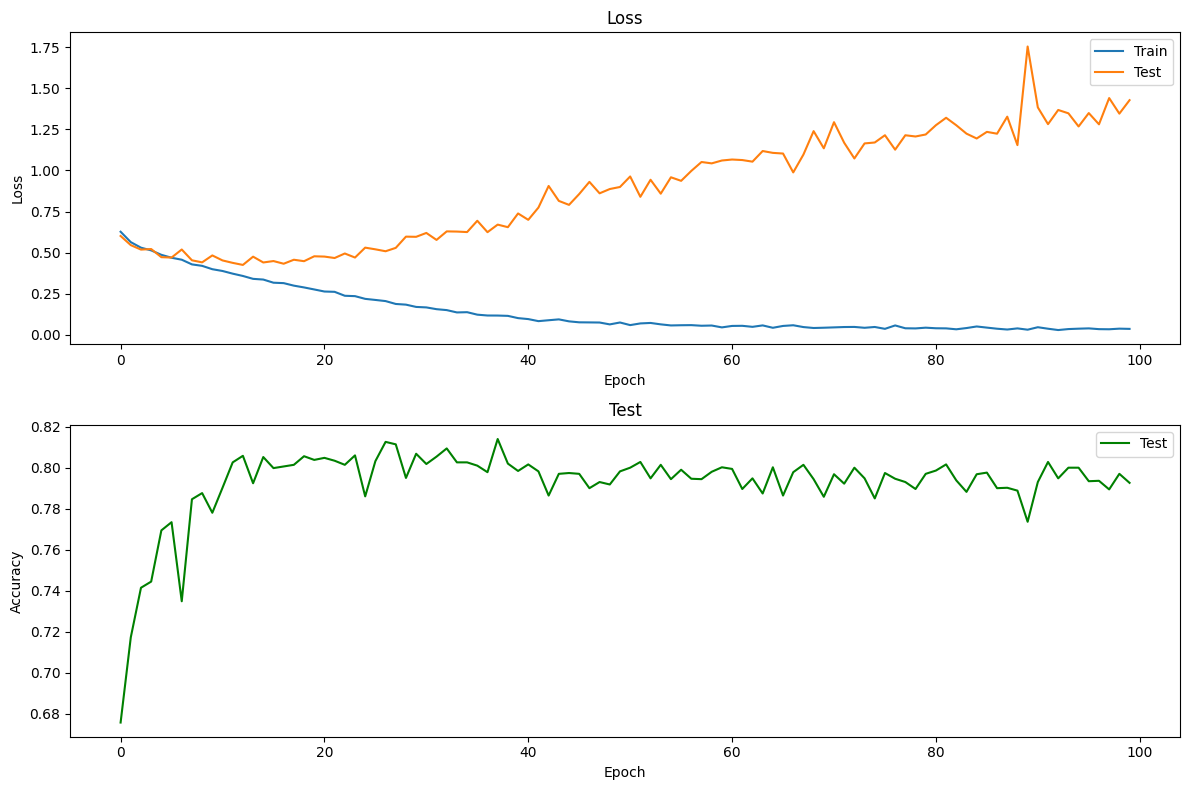

In [ ]:
# Plot results
train_avg_loss = [t.item() for t in train_avg_loss]
test_avg_loss = [t.item() for t in test_avg_loss]

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(train_avg_loss, label="Train")
plt.plot(test_avg_loss, label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(test_accuracy, label="Test", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Test")
plt.legend()

plt.tight_layout()
plt.show()

**Discussion**:
- Train Loss (blue line) decrease steady. This indicates that your model is fitting the training data extremely well.
- Thes loss decrease initially after 10 epochs, then starts to rise significantly because of overfitting. On the other hand, test accuracy stagnates or slightly decreases.
- The test loss and accuracy experience slight fluctuation, so reducing the learning rate is an option for smoother curves.

## Feedback

Now that you are done with this final deep-learning assignment here are some final questions about the exercises you were required to solve:

<span style="color:blue">How much time did you spend on this homework?</span>

around 7 hours per person

<span style="color:blue">Do you feel confortable with what it means to define a neural network and train it?</span>

Yes, we understand how to prepare dataset, then know building, training and evaluate models.

<span style="color:blue">Do you think you now have enough preliminary knowledge for successfully starting to work on your course final project?</span>

Yes, we think this provide a good foundation for the project.

<span style="color:blue">If you had to go through the two homeworks again, is there something you would have liked to explore more or explained more into detail?</span>

Until now, we don't have any idea.